Imports & Load Data

In [1]:
import pandas as pd
import numpy as np

# Load unified dataset
df = pd.read_csv("phase3_unified.csv")

df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort properly
df = df.sort_values(
    by=["device_id", "timestamp"]
).reset_index(drop=True)

print("Rows:", len(df))
print("Devices:", df["device_id"].nunique())


Rows: 1515717
Devices: 8


Basic Derived Features

In [2]:
# Depth of Discharge
df["dod"] = 100 - df["soc"]

# Absolute current
df["abs_current"] = df["current"].abs()

# Temperature delta
df["temp_delta"] = df.groupby("device_id")["temperature"].diff().fillna(0)

# Voltage delta
df["voltage_delta"] = df.groupby("device_id")["pack_voltage"].diff().fillna(0)


Rolling Windows

In [3]:
#We now use cycle-based rolling, not raw seconds
WINDOWS = [5, 10, 20]  # cycles-based window


Rolling Voltage Features

In [4]:
for win in WINDOWS:

    df[f"voltage_mean_{win}"] = (
        df.groupby("device_id")["pack_voltage"]
        .rolling(win, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    df[f"voltage_std_{win}"] = (
        df.groupby("device_id")["pack_voltage"]
        .rolling(win, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    )


Rolling Temperature Features

In [5]:
for win in WINDOWS:

    df[f"temp_mean_{win}"] = (
        df.groupby("device_id")["temperature"]
        .rolling(win, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

    df[f"temp_max_{win}"] = (
        df.groupby("device_id")["temperature"]
        .rolling(win, min_periods=1)
        .max()
        .reset_index(level=0, drop=True)
    )


Coulomb Throughput

In [6]:
for win in WINDOWS:

    df[f"coulomb_sum_{win}"] = (
        df.groupby("device_id")["abs_current"]
        .rolling(win, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )


Internal Resistance Estimate

In [7]:
df["delta_v"] = df.groupby("device_id")["pack_voltage"].diff().fillna(0)
df["delta_i"] = df.groupby("device_id")["current"].diff().replace(0, np.nan)

df["internal_resistance"] = (df["delta_v"] / df["delta_i"]).fillna(0)

for win in WINDOWS:
    df[f"rint_mean_{win}"] = (
        df.groupby("device_id")["internal_resistance"]
        .rolling(win, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )


DEGRADATION FEATURES

In [8]:
df["soh_delta"] = df.groupby("device_id")["soh"].diff().fillna(0)

for win in WINDOWS:
    df[f"soh_trend_{win}"] = (
        df.groupby("device_id")["soh"]
        .rolling(win, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )


Cycle Progress Ratio

In [9]:
max_cycle_per_device = df.groupby("device_id")["cycle_count"].transform("max")

df["cycle_ratio"] = df["cycle_count"] / max_cycle_per_device


Degradation Acceleration

In [10]:
df["cycle_delta"] = df.groupby("device_id")["cycle_count"].diff().fillna(0)

df["degradation_acceleration"] = df["soh_delta"] / (df["cycle_delta"] + 1e-6)


Fast Charge Rolling Count

In [11]:
df["fast_charge_flag"] = (df["event"] == "fast_charge").astype(int)

for win in WINDOWS:
    df[f"fast_charge_count_{win}"] = (
        df.groupby("device_id")["fast_charge_flag"]
        .rolling(win, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )


Source Encoding (Important for Mixed Domain)

In [12]:
df["source_encoded"] = (df["source"] == "synthetic").astype(int)


Final Cleaning

In [13]:
df = df.replace([np.inf, -np.inf], 0)
df = df.fillna(0)


Select Final Dataset

In [14]:
base_cols = [
    "device_id", "timestamp",
    "pack_voltage", "current", "temperature",
    "soc", "cycle_count", "soh",
    "event", "source"
]

feature_cols = [c for c in df.columns if c not in base_cols]

final_df = df[base_cols + feature_cols]

print("Total features:", len(feature_cols))
print("Final shape:", final_df.shape)


Total features: 37
Final shape: (1515717, 47)


Save Phase 4 Output

In [15]:
final_df.to_csv("phase4_features.csv", index=False)

print("Phase 4 (Feature Engineering) completed successfully")


Phase 4 (Feature Engineering) completed successfully


Visualisation

SoH vs Cycle Ratio

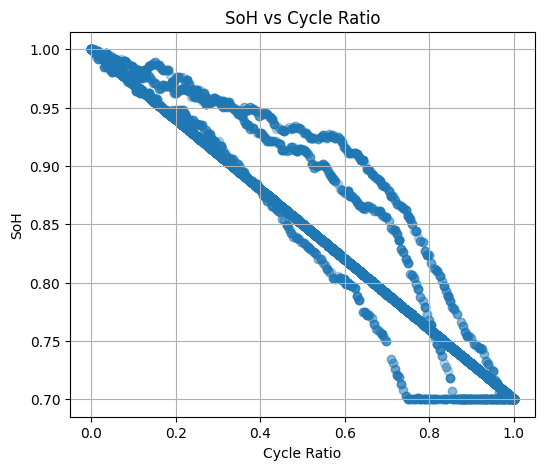

In [16]:
import matplotlib.pyplot as plt

sample_df = final_df.sample(20000, random_state=42)

plt.figure(figsize=(6,5))
plt.scatter(sample_df["cycle_ratio"], sample_df["soh"], alpha=0.3)
plt.xlabel("Cycle Ratio")
plt.ylabel("SoH")
plt.title("SoH vs Cycle Ratio")
plt.grid(True)
plt.show()


SoH Trend Feature Validation

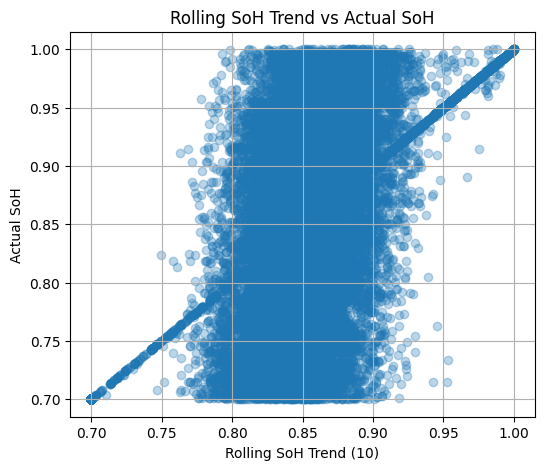

In [17]:
plt.figure(figsize=(6,5))
plt.scatter(sample_df["soh_trend_10"], sample_df["soh"], alpha=0.3)
plt.xlabel("Rolling SoH Trend (10)")
plt.ylabel("Actual SoH")
plt.title("Rolling SoH Trend vs Actual SoH")
plt.grid(True)
plt.show()


Internal Resistance vs SoH

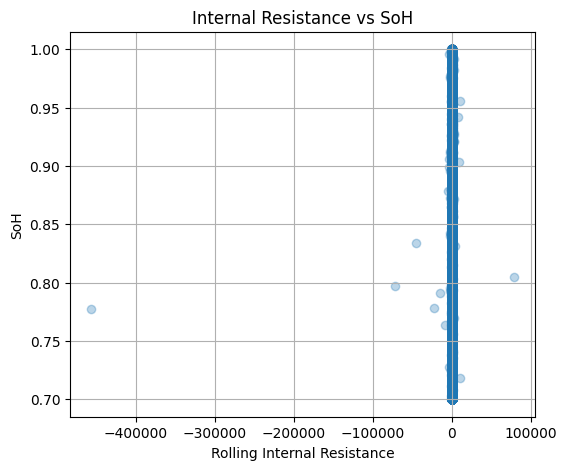

In [18]:
plt.figure(figsize=(6,5))
plt.scatter(sample_df["rint_mean_10"], sample_df["soh"], alpha=0.3)
plt.xlabel("Rolling Internal Resistance")
plt.ylabel("SoH")
plt.title("Internal Resistance vs SoH")
plt.grid(True)
plt.show()


Feature Correlation Heatmap

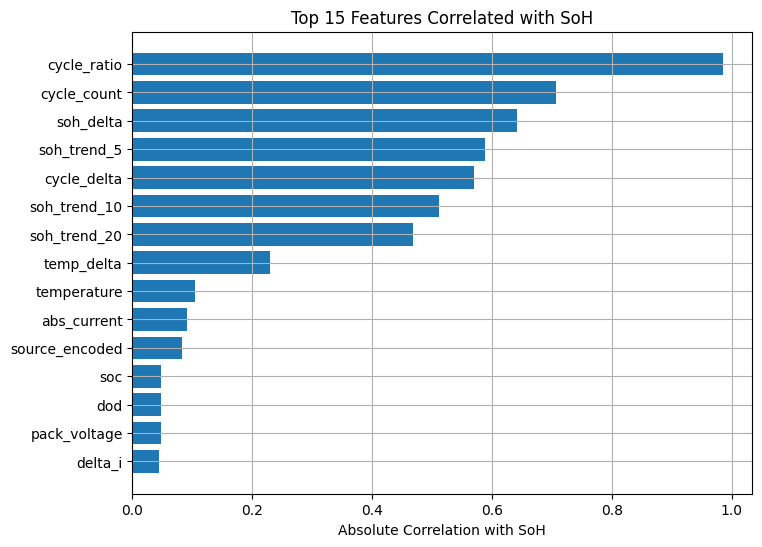

In [21]:
import matplotlib.pyplot as plt

# Sample data
corr_sample = final_df.sample(20000, random_state=42)

# Numeric only
numeric_df = corr_sample.select_dtypes(include=["number"])

# Correlation
corr_matrix = numeric_df.corr()

# Correlation with SoH
corr_with_soh = corr_matrix["soh"].sort_values(ascending=False)

# Remove self-correlation
corr_with_soh = corr_with_soh.drop("soh")

# Take top 15 absolute correlations
top_features = corr_with_soh.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features.index[::-1], top_features.values[::-1])
plt.xlabel("Absolute Correlation with SoH")
plt.title("Top 15 Features Correlated with SoH")
plt.grid(True)
plt.show()
